In [99]:
### Import Libraries
import numpy as np
import cv2
import glob

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from moviepy.editor import VideoFileClip

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
def Get_HoG_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    color_hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    color_hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    color_hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((color_hist1[0], color_hist2[0], color_hist3[0]))
    return hist_features

In [101]:
# Function to extract features from a many images
def features_exteraction(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        
        if cspace != 'RGB':
            change_cspace = "cv2.COLOR_RGB2" + cspace
            feature_image = cv2.cvtColor(image, eval(change_cspace))
        else: 
            feature_image = np.copy(image)      
            
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(Get_HoG_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = Get_HoG_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    return features

In [102]:
# Function to extract features from a single image
def single_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    image = imgs

    if cspace != 'RGB':
        change_cspace = "cv2.COLOR_RGB2" + cspace
        feature_image = cv2.cvtColor(image, eval(change_cspace))
    else: 
        feature_image = np.copy(image)      

    spatial_features = bin_spatial(feature_image, size=spatial_size)

    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(Get_HoG_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = Get_HoG_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    return features

In [103]:
# Sliding Window
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

In [104]:
# Search and Classify
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    on_windows = []
    count = 0
    for window in windows:

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        features = single_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

# Heatmap
def heatmap(heatmap_image, windows):
    
    for window in hot_windows:
        heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5

    return heatmap_image

In [105]:
# Threshold image
def thresholding(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    new_heatmap[new_heatmap <= threshold] = 0
    return new_heatmap

# Draw boxes around label
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [106]:
### Load images
images = glob.glob('vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)
print(len(cars))
images = glob.glob('non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)
print(len(notcars))

8792
8968


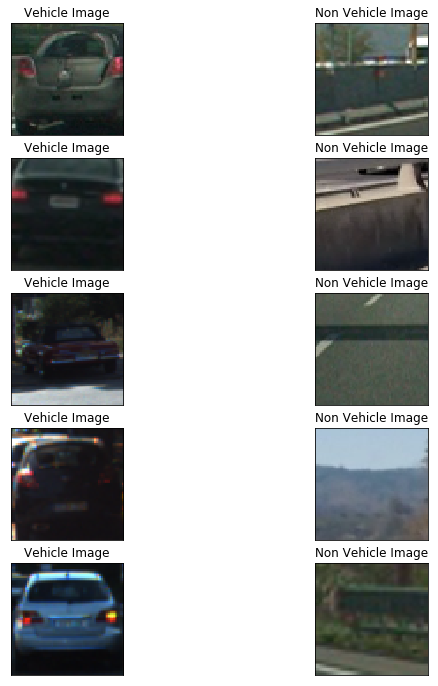

In [107]:
### Plot random images from dataset
fig = plt.figure(figsize=(10, 12))

# Create subplots in figure
for r in range(10):
    img = fig.add_subplot(5,2,r+1)
    if r%2==0:
        idx = np.random.randint(1,len(cars))
        plt.imshow(mpimg.imread(cars[idx]))
        img.set_title("Vehicle Image")
    else:
        idx = np.random.randint(1,len(notcars))
        plt.imshow(mpimg.imread(notcars[idx]))
        img.set_title("Non Vehicle Image")
        
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [108]:
### Parameters
cspace = 'HSV'
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

In [109]:
%%time
# Get features for car images
car_features = features_exteraction(cars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

# Get features for non-car images
notcar_features = features_exteraction(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

CPU times: user 1min 42s, sys: 4.76 s, total: 1min 47s
Wall time: 2min 3s


In [110]:
### Create training and test set

# Array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=12412)
X_train, y_train = shuffle(X_train, y_train, random_state=2342)

In [111]:
%%time
svc = LinearSVC(C=1.0)

svc.fit(X_train, y_train)
# Check the accuracy
print('Accuracy = ', round(svc.score(X_test, y_test), 4))

Accuracy =  0.9935
CPU times: user 16.7 s, sys: 2.11 s, total: 18.8 s
Wall time: 21.7 s


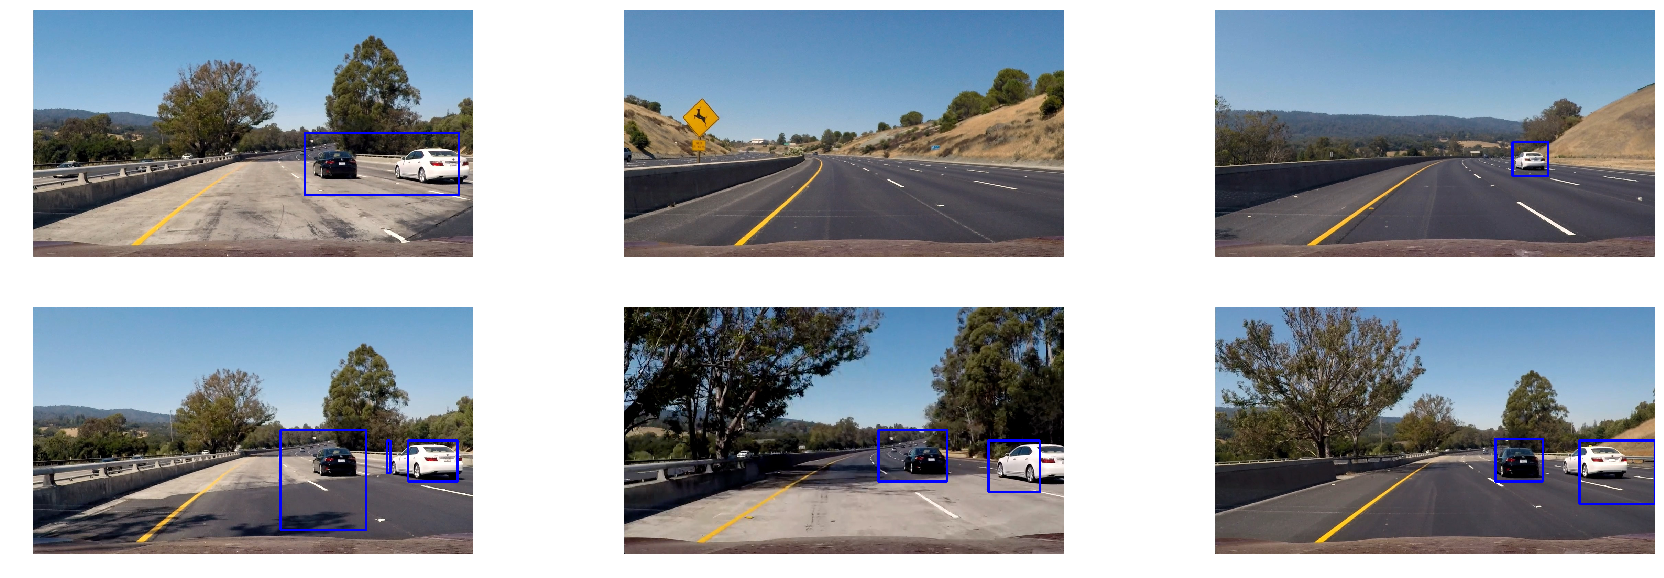

In [112]:
### Test Sliding Window on test images
images = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(30, 10))

for i in range(len(images)):
    
    car_image = mpimg.imread(images[i])
    car_image = car_image.astype(np.float32)/255

    windows1 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    
    windows2 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.8), int(car_image.shape[0]/1.4)], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
    windows4 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.6), int(car_image.shape[0]/1.2)], 
                           xy_window=(160, 160), xy_overlap=(0.75, 0.75))
    
    windows = windows1 + windows2 + windows3 + windows4

    hot_windows = search_windows(car_image, windows, svc, X_scaler, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    heatmap_image = np.zeros_like(mpimg.imread(images[i]))
    heatmap_image = heatmap(heatmap_image, hot_windows)
    heatmap_image = thresholding(heatmap_image, 5)
    
    labels = label(heatmap_image)    
    
    # Boundinx Box around label
    image = draw_labeled_bboxes(mpimg.imread(images[i]), labels)
    
    # Boundinx Boxes around searched vehicle(s)
    window_img_2 = draw_boxes(mpimg.imread(images[i]), hot_windows, color=(0, 0, 255), thick=6)
    
    fig.add_subplot(2,3,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [113]:
### Video pipeline
def process_video(image):
    global prev_heatmap, prev_heatmap_list
    car_image = image.astype(np.float32)/255
    heatmap_factor = 0.9

    windows1 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.8), int(car_image.shape[0]/1.4)], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
    windows4 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.6), int(car_image.shape[0]/1.2)], 
                           xy_window=(160, 160), xy_overlap=(0.75, 0.75))

    windows = windows1 + windows2 + windows3 + windows4

    hot_windows = search_windows(car_image, windows, svc, X_scaler, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    prev_heatmap_list.append(hot_windows)
    
    # Create heatmap
    heatmap_image = np.zeros_like(car_image)
    
    if len(prev_heatmap_list) > 15:
        prev_heatmap_list.pop(0)
        for prev_hot_windows in prev_heatmap_list:
            for window in prev_hot_windows:
                heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
    elif len(prev_heatmap_list) < 15:
        for window in hot_windows:
            heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5

    heatmap_image = cv2.GaussianBlur(heatmap_image,(5,5),0)
    
    heatmap_image = thresholding(heatmap_image, 5) #4
     
    if prev_heatmap == None:
        prev_heatmap = heatmap_image
    else:
        heatmap_image = prev_heatmap * heatmap_factor + heatmap_image * (1 - heatmap_factor)
        heatmap_image = thresholding(heatmap_image, 10) #6
        prev_heatmap = heatmap_image
    
    labels = label(heatmap_image)
    image = draw_labeled_bboxes(image, labels)
    
    return image

In [86]:
### Run on test video
prev_heatmap = None
prev_heatmap_list = []

output = 'output.mp4'

clip1 = VideoFileClip("./project_video.mp4")

output_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project5_test_1.mp4
[MoviePy] Writing video project5_test_1.mp4


100%|█████████▉| 1260/1261 [15:21<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_test_1.mp4 

CPU times: user 14min 43s, sys: 28.4 s, total: 15min 12s
Wall time: 15min 22s
